In [1]:
from os.path import join as pjoin
import os
import numpy as np
import seaborn as sns
import scipy
from scipy.signal import periodogram
import matplotlib.pyplot as plt

In [2]:
# load example time series
melodic_outdir_s1 = '/home/homeGlobal/oli/somato/scratch/ica/MELODIC/melodic_wf_workdir/subject_lvl/somato_melodic_wf/melodic/mapflow/_melodic0/'
comp1_tsfile = pjoin(melodic_outdir_s1, 'report/t1.txt')
ts_arr = np.loadtxt(comp1_tsfile)

In [3]:
# plot time series
#g = sns.lineplot(y=ts_arr, x=range(len(ts_arr)))
#g.set_title('time course of test component')

Calculate power spectrum manually via scipy

In [4]:
frequencies, powerdensities = periodogram(ts_arr)

In [5]:
#g = sns.lineplot(y=powerdensities, x=frequencies)
#g.set_title('power spectrum of test IC')

In [6]:
maxid = np.argmax(powerdensities)

In [7]:
maxfreq = frequencies[maxid]
print(maxfreq)

0.00390625


Nice! This *looks* like the frequency of one stimulation cycle, although it technically should be .039 ...

Open question remains
- is this frequency dominant in many components
- ... also in components that anatomically have nothing to do with the stimulation (this example IC also looks like a snow storm)
- Do we allow small deviations from the stimulation cycle frequency? If so, how large deviations?

In [8]:
ncomps=50
maxfreqs = []
hitcount=0
for comp_id in range(1,ncomps+1):
    tsfile = pjoin(melodic_outdir_s1, 'report/t%i.txt' % comp_id)
    ts_arr = np.loadtxt(tsfile)
    #sns.lineplot(y=ts_arr, x=range(len(ts_arr)))
    frequencies, powerdensities = periodogram(ts_arr)
    maxid = np.argmax(powerdensities)
    maxfreq, maxpower = frequencies[maxid], powerdensities[maxid]
    if str(maxfreq%.00390625) == '0.0':
        hitcount = hitcount + 1
    print('maximum frequency %.5f with power %.2f (modulo maxfreq %s)' % (maxfreq, maxpower, str(maxfreq%.00390625)))
    maxfreqs.append(maxfreq)
    
maxfreqs = np.array(maxfreqs)

maximum frequency 0.00391 with power 28.27 (modulo maxfreq 0.0)
maximum frequency 0.00195 with power 71.82 (modulo maxfreq 0.001953125)
maximum frequency 0.00391 with power 89.61 (modulo maxfreq 0.0)
maximum frequency 0.00391 with power 94.21 (modulo maxfreq 0.0)
maximum frequency 0.00781 with power 46.69 (modulo maxfreq 0.0)
maximum frequency 0.00195 with power 68.82 (modulo maxfreq 0.001953125)
maximum frequency 0.00391 with power 60.50 (modulo maxfreq 0.0)
maximum frequency 0.00391 with power 151.30 (modulo maxfreq 0.0)
maximum frequency 0.00391 with power 545.48 (modulo maxfreq 0.0)
maximum frequency 0.00391 with power 343.64 (modulo maxfreq 0.0)
maximum frequency 0.00391 with power 263.71 (modulo maxfreq 0.0)
maximum frequency 0.18164 with power 17.84 (modulo maxfreq 0.001953125)
maximum frequency 0.00195 with power 213.96 (modulo maxfreq 0.001953125)
maximum frequency 0.00195 with power 36.29 (modulo maxfreq 0.001953125)
maximum frequency 0.00391 with power 522.26 (modulo maxfreq

In [9]:
print('%i of the 50 ICs have a maximum frequency thats a multiple of the stimulation cycle' % hitcount)

28 of the 50 ICs have a maximum frequency thats a multiple of the stimulation cycle


In [10]:
unique, counts = np.unique(maxfreqs, return_counts=True)

In [11]:
print('Among the maximum frequency values of the 50 components, there are %i unique.' % len(unique))

Among the maximum frequency values of the 50 components, there are 8 unique.


In [12]:
#fig, axis = plt.subplots(figsize=(20,5))#

#g = sns.lineplot(x=unique, y=counts, ax=axis)
#g.set_xticks(unique)
#g.set_xticklabels(['%.4f' % u for u in unique], rotation=90)
#g.set_title('counts of unique maxfrequencies across the 50 ICs for subject 1')

In [13]:
for uni in unique:
    if uni % 0.00390625 == 0:
        print('multiple of stimulation cycle: %f' % uni)
    else:
        print('noise component: %f' % uni)

noise component: 0.001953
multiple of stimulation cycle: 0.003906
multiple of stimulation cycle: 0.007812
noise component: 0.048828
noise component: 0.076172
multiple of stimulation cycle: 0.078125
noise component: 0.181641
noise component: 0.416016


## intermediate conclusion

for the example subject number one ...

- 28 of the 50 ICs have a maximum frequency thats a multiple of the stimulation cycle.
- There are only 8 *unique* maximum frequencies across the 50 components
- 3 of which are a multiple of the stimulation cycle

# Find components whose max frequency is exactly our stimulation cycle

In [14]:
# get those cycle-matching little cuties

ncomps=50
matching_comps = []
matching_powers = []

for idx, comp_id in enumerate(range(1,ncomps+1)):
    tsfile = pjoin(melodic_outdir_s1, 'report/t%i.txt' % comp_id)
    ts_arr = np.loadtxt(tsfile)
    #sns.lineplot(y=ts_arr, x=range(len(ts_arr)))
    frequencies, powerdensities = periodogram(ts_arr)
    maxid = np.argmax(powerdensities)
    maxfreq, maxpower = frequencies[maxid], powerdensities[maxid]
    
    if maxfreq == .00390625:
        matching_comps.append(idx)
        matching_powers.append(maxpower)

In [15]:
print(matching_comps)

[0, 2, 3, 6, 7, 8, 9, 10, 14, 17, 18, 25, 28, 30, 31, 32, 34, 36, 37, 39, 40, 43]


22 components from this subject have a maximum frequency that matches the stimulation cycle.

## Plot their time series & power spectrum

The matching ICs are marked with bold row titles

In [16]:
sns.set_style('white')
sns.set_context('notebook')

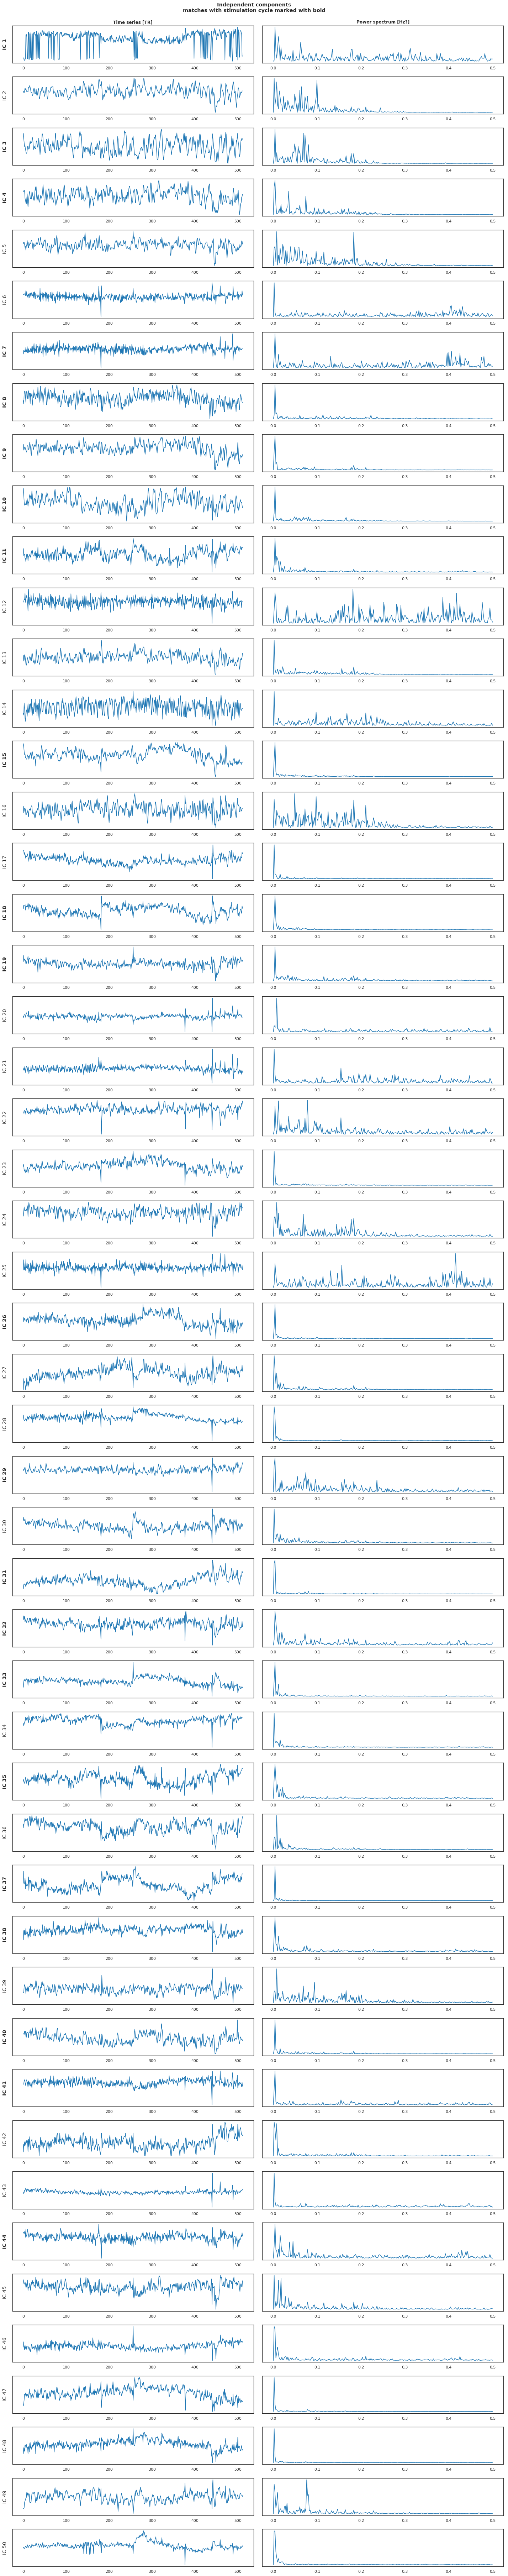

In [17]:
fig, axs = plt.subplots(ncols=2, nrows=ncomps, figsize=(20,100))
for comp_id, axis in zip(range(ncomps), axs):
    # load time series file output from melodic
    tsfile = pjoin(melodic_outdir_s1, 'report/t%i.txt' % (comp_id+1))
    ts_arr = np.loadtxt(tsfile)
    # calculate powerspectrum
    frequencies, powerdensities = periodogram(ts_arr)
    # plot ts and powerspectrum 
    sns.lineplot(y=ts_arr, x=range(len(ts_arr)), ax=axis[0])
    sns.lineplot(y=powerdensities, x=frequencies, ax=axis[1])
    # set row title bold if ic matches stimulation frequency
    if comp_id in matching_comps:
        axis[0].set_ylabel('IC %i' % (comp_id+1), rotation=90, size='large', fontweight='bold')
    else:
        axis[0].set_ylabel('IC %i' % (comp_id+1), rotation=90, size='large')
    # remove y ticks for less clutter
    axis[0].set_yticklabels([])
    axis[1].set_yticklabels([])
    
# set titles for the two rows
axs[0][0].set_title('Time series [TR]', fontweight='bold')
axs[0][1].set_title('Power spectrum [Hz?]', fontweight='bold')
fig.suptitle('Independent components\nmatches with stimulation cycle marked with bold', fontweight='bold', y=1.005)
fig.tight_layout()